# Face Recognition using Siamese Network

### Install and Import Dependencies

In [ ]:
# Install dependencies
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [1]:
# Import dependencies
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, Input, Flatten, MaxPooling2D

### Set GPU Growth

In [3]:
# Avoid OOM (Out of Memory) errors by setting GPU Memory Consumption Growth
# GPU stands for Graphical Processing Unit
# gpus = tf.config.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Number of physical devices in the machine
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
# Number of CPU's in the machine
cpus = tf.config.list_physical_devices('CPU')
len(cpus)

1

In [6]:
# Printing the number of CPU's in the machine
for cpu in cpus:
    print(cpu)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [7]:
# Number of GPU's in the machine
len(gpus)

0

In [8]:
# Printing the GPU's in the machine
for gpu in gpus:
    print(gpu)

### Create Folder Structures

In [9]:
# POS_PATH for positive image path which has the correct images
POS_PATH = os.path.join('data', 'positive')

# NEG_PATH for negative image path which has incorrect images
NEG_PATH = os.path.join('data', 'negative')

# ANC_PATH for anchor image path which has the image to be tested against negative and positive images
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
# 'makedirs' makes the directory from scratch that is it creates all the intermediate directories
# Like in this example it will create 'data' directory under which 'positive' directory whould be made
# So the complete path using 'makedirs' will look like 'data\positive\'
# Whereas 'mkdir' creates single sub-directory that is,
# it would make just the 'positive' directory and not its super directory 'data'
# The complete path using 'mkdir' would look like 'positive\'
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [10]:
# Printing the path
print(POS_PATH)
print(NEG_PATH)
print(ANC_PATH)

data\positive
data\negative
data\anchor


### Collect Negatives from Labelled Faces in the Wild Dataset

In [ ]:
# Link to labelled faces in the wild dataset (Negative Input) : http://vis-www.cs.umass.edu/lfw/#download
# Uncompress Tar GZ labelled faces in the wild dataset
!tar -xf lfw.tgz

In [ ]:
# Move 'lfw' images to 'data\Negative'
# The first two lines of code generates the entire set of images from each files in each directory
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        
#         EX_PATH for existing path of the labelled images in the wild dataset
        EX_PATH = os.path.join('lfw', directory, file)
        
#         NEW_PATH for the path of 'Negative' directory in 'data' directory
        NEW_PATH = os.path.join(NEG_PATH, file)
        
#         Moving all labelled images into NEW_PATH
        os.replace(EX_PATH, NEW_PATH)

### Collect Positives and Anchors using Webcam

In [11]:
# Import uuid library to generate unique names to each image
# uuid stands for Univerally Unique IDentifier
import uuid

In [12]:
# Generation of unique filename via different forms
print('{}.jpg'.format(uuid.uuid1()))
print('{}.jpg'.format(uuid.uuid4()))

# Just to check how the unique filename is generated using 'uuid' along with the path
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

8a45c640-3934-11ee-8363-f75f2ef10444.jpg
26671329-f80b-49b6-8f4b-61e711447352.jpg


'data\\anchor\\8a45c641-3934-11ee-aa5b-f75f2ef10444.jpg'

In [13]:
# Establish a connection to the Webcam
# Here, '0' is the device's webcam's location
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
#     Cut down frame to 250x250px
    frame = frame[170:170+250, 220:220+250, :]
    
#     Collect anchor images
#     On clicking 'a' on keyboard an anchor image would be created and stored in the desired directory
    if cv2.waitKey(1) & 0xFF == ord('a'):
#         Create the unique anchor image file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         Store the image in respective directory (Write out anchor image)
        cv2.imwrite(imgname, frame)
    
#     Collect positive images
#     On clicking 'p' on keyboard a positive image would be created and stored in the desired directory
    if cv2.waitKey(1) & 0xFF == ord('p'):
#         Create the unique positive image file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         Store the image in respective directory (Write out positive image)
        cv2.imwrite(imgname, frame)
    
#     Show Image back to screen
    cv2.imshow("Image Collection", frame)
    
#     Breaking gracefully
#     On clicking 'q' on keyboard, the looping would break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# Release the Webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

(250, 250, 3)


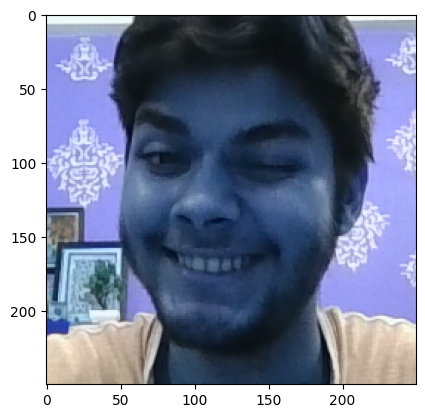

In [14]:
# Print the frame shape
print(frame.shape)
plt.imshow(frame)
plt.show()
# Image slicing
# print(frame[170:170+250, 220:220+250, :].shape)
# plt.imshow(frame[170:170+250, 220:220+250, :])
# plt.show()
# print(frame[250:250+250, 120:120+250, :].shape)
# plt.imshow(frame[250:250+250, 120:120+250, :])
# plt.show()

### Get Image Directories

In [15]:
# Getting the image file path from each directory
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [16]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\66d0d8ac-37ad-11ee-afa6-346f24d0c492.jpg'


### Pre-Processing (Scale and Resize)

In [17]:
def preprocess(file_path):
    
#     Read the image from image file path
    byte_img = tf.io.read_file(file_path)
    
#     Load the image
    img = tf.io.decode_jpeg(byte_img)
    
#     Resize the image to 105x105x3
    img = tf.image.resize(img, (105, 105))
    
#     Scale the image to be between 0 and 1
    img = img / 255.0
    
#     Return the image
    return img

In [18]:
# Testing the above file path
img = preprocess('data\\anchor\\66d0d8ac-37ad-11ee-afa6-346f24d0c492.jpg')

In [19]:
# Getting details of the image
img

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.972549  , 0.9764706 , 0.9529412 ],
        [0.972549  , 0.9764706 , 0.9529412 ],
        [0.96956116, 0.9770308 , 0.95172733],
        ...,
        [0.75527525, 0.7351405 , 0.69348603],
        [0.71233153, 0.6851406 , 0.64583826],
        [0.6645169 , 0.63332665, 0.5959806 ]],

       [[0.96862745, 0.972549  , 0.9490196 ],
        [0.96890754, 0.9728291 , 0.9492997 ],
        [0.970775  , 0.9782446 , 0.9529412 ],
        ...,
        [0.70319456, 0.6629851 , 0.627691  ],
        [0.70332134, 0.65206075, 0.6204081 ],
        [0.7144791 , 0.6623783 , 0.6271909 ]],

       [[0.96862745, 0.972549  , 0.9490196 ],
        [0.96890754, 0.9728291 , 0.9492997 ],
        [0.970775  , 0.9782446 , 0.9529412 ],
        ...,
        [0.72037256, 0.64763683, 0.61486375],
        [0.7275644 , 0.6443444 , 0.6149926 ],
        [0.74181896, 0.65506643, 0.6216731 ]],

       ...,

       [[0.8524632 , 0.79363966, 0.66852295],
        [0.84

In [20]:
# Printing the minimum and maximum pixel value in image
print(img.numpy().min())
print(img.numpy().max())

0.0
1.0


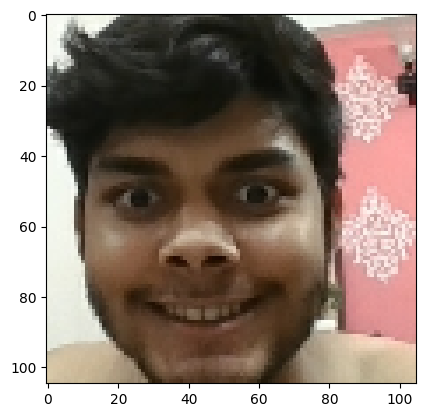

In [21]:
plt.imshow(img)

In [22]:
# dataset.map(preprocess)

### Create Labelled Dataset

In [23]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [24]:
tf.zeros(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [25]:
tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>

In [26]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))
iterator_labels = class_labels.as_numpy_iterator()
iterator_labels.next()

1.0

In [61]:
# (anchor, positives) => 1, 1, 1, 1, 1
# (anchor, negatives) => 0, 0, 0, 0, 0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [62]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [63]:
data.as_numpy_iterator()

In [64]:
samples = data.as_numpy_iterator()
example = samples.next()

In [65]:
example

(b'data\\anchor\\723fc1e6-37ad-11ee-a92f-346f24d0c492.jpg',
 b'data\\positive\\7f515760-37ad-11ee-bf2b-346f24d0c492.jpg',
 1.0)

### Build Train and Test Partition

In [66]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

tf.Tensor(
[[[0.972549   0.9764706  0.94509804]
  [0.97226894 0.9767507  0.94509804]
  [0.96862745 0.98039216 0.94509804]
  ...
  [0.71191144 0.68825525 0.6441954 ]
  [0.6702881  0.64172995 0.5971855 ]
  [0.66834515 0.63940024 0.59504914]]

 [[0.972549   0.9764706  0.94565827]
  [0.97226894 0.9767507  0.94565827]
  [0.96862745 0.98039216 0.94565827]
  ...
  [0.70046014 0.65368146 0.6168934 ]
  [0.6885954  0.63987595 0.59415764]
  [0.7091503  0.6531279  0.6097106 ]]

 [[0.972549   0.9764706  0.9529412 ]
  [0.97226894 0.9767507  0.9529412 ]
  [0.96862745 0.98039216 0.9529412 ]
  ...
  [0.7243142  0.6449113  0.6096172 ]
  [0.7338869  0.64861274 0.6114179 ]
  [0.7484594  0.6533147  0.61262727]]

 ...

 [[0.867507   0.87834907 0.8257591 ]
  [0.88574773 0.8914434  0.8383154 ]
  [0.8981104  0.9000889  0.84186333]
  ...
  [0.87090623 0.79994446 0.6822974 ]
  [0.8775311  0.80656934 0.6924704 ]
  [0.88795525 0.8169935  0.7028945 ]]

 [[0.8423568  0.83786833 0.771395  ]
  [0.7586232  0.7471385  0

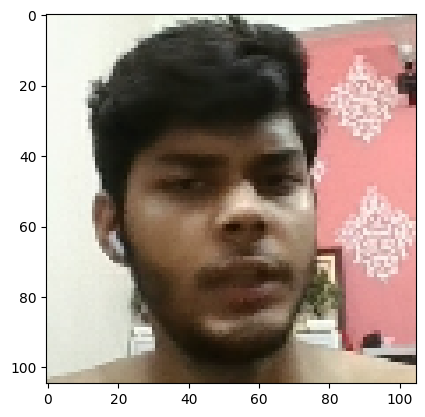

In [67]:
res = preprocess_twin(*example)
print(res[0])
plt.imshow(res[0])

tf.Tensor(
[[[0.95686275 0.9764706  0.9490196 ]
  [0.95686275 0.9764706  0.9490196 ]
  [0.9604108  0.9764706  0.9490196 ]
  ...
  [0.7082699  0.68246627 0.65054464]
  [0.66768706 0.63256633 0.59735894]
  [0.6730181  0.6338024  0.59458673]]

 [[0.95686275 0.9764706  0.9490196 ]
  [0.9579432  0.9764506  0.9490396 ]
  [0.9647059  0.9761905  0.9492997 ]
  ...
  [0.6919835  0.6551954  0.6139256 ]
  [0.70016    0.64525807 0.6013005 ]
  [0.71558625 0.64976656 0.6064359 ]]

 [[0.9604108  0.9764706  0.9490196 ]
  [0.9647059  0.9761905  0.9492997 ]
  [0.9647059  0.972549   0.9529412 ]
  ...
  [0.71585304 0.64526474 0.598206  ]
  [0.7364346  0.65346134 0.6022876 ]
  [0.74276376 0.64939314 0.59841275]]

 ...

 [[0.85313904 0.7943155  0.6727469 ]
  [0.8528211  0.7894491  0.67015475]
  [0.83368903 0.7670224  0.64937526]
  ...
  [0.7900093  0.7137255  0.6014005 ]
  [0.80209416 0.7348673  0.6172202 ]
  [0.7886088  0.7219421  0.6042951 ]]

 [[0.84976655 0.7836601  0.6657329 ]
  [0.84595835 0.7792917  0

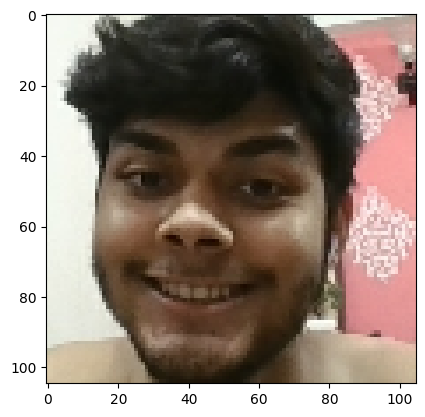

In [68]:
print(res[1])
plt.imshow(res[1])

In [69]:
print(res[2])

1.0


### Build Data Loader Pipeline

In [70]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [71]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

3


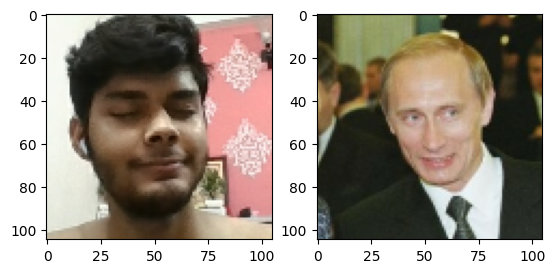

Label :  0.0


In [80]:
samples = data.as_numpy_iterator()
sample_1 = samples.next()
print(len(sample_1))
# print(len(samples.next()))
plt.subplot(1, 2, 1)
plt.imshow(sample_1[0])
# plt.show()
plt.subplot(1, 2, 2)
plt.imshow(sample_1[1])
plt.show()
print("Label : ", sample_1[2])
# samples.next()

### Training Partition

In [81]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [83]:
print(round(len(data)*.7))
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

420


In [84]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [85]:
train_samples = train_data.as_numpy_iterator()
print(len(train_samples.next()[0]))

16


### Testing Partiton

In [86]:
print(round(len(data)*.3))
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

180


In [87]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

16


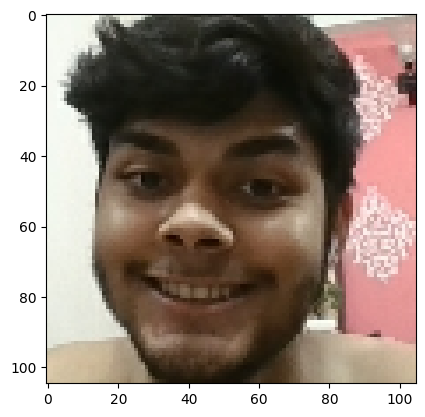

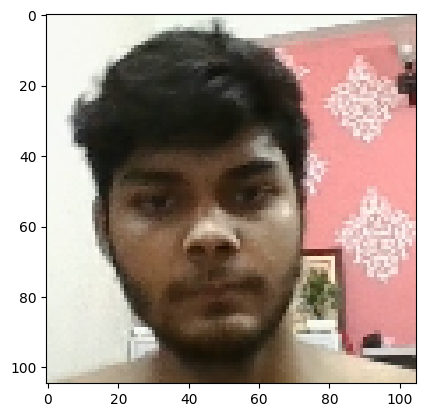

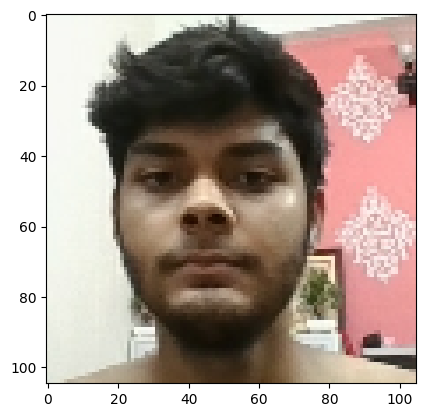

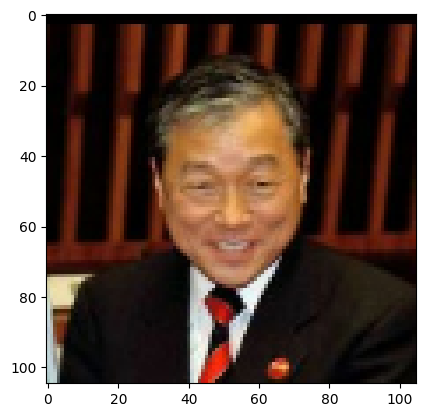

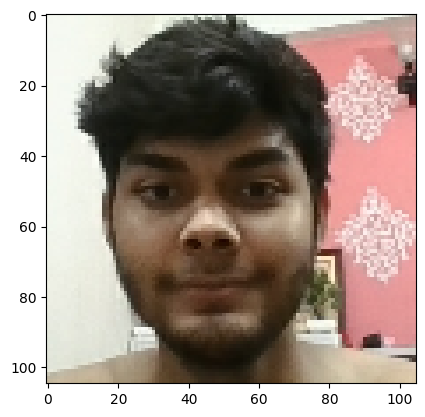

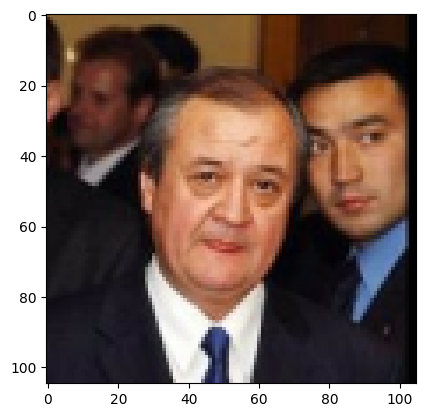

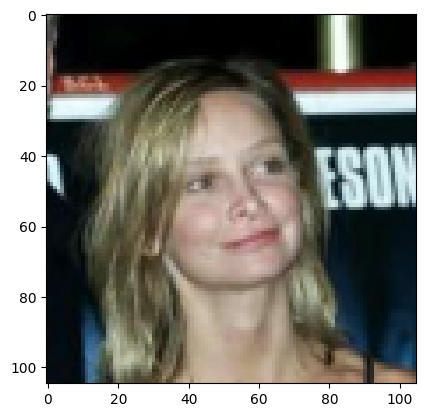

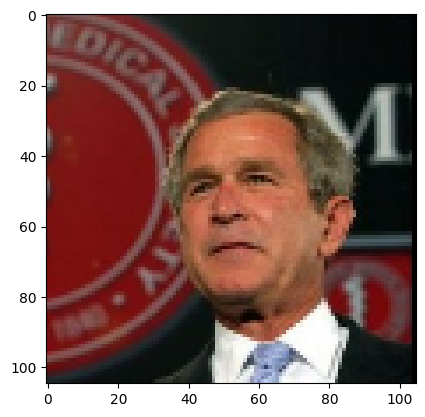

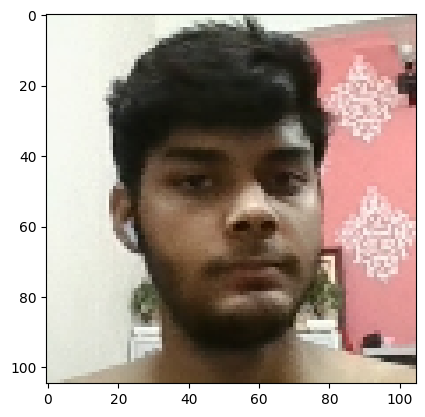

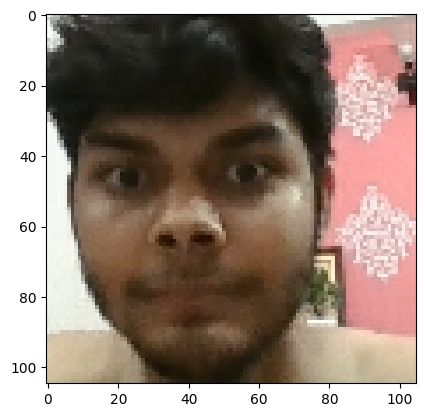

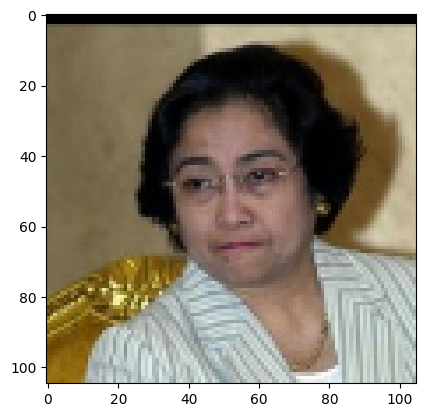

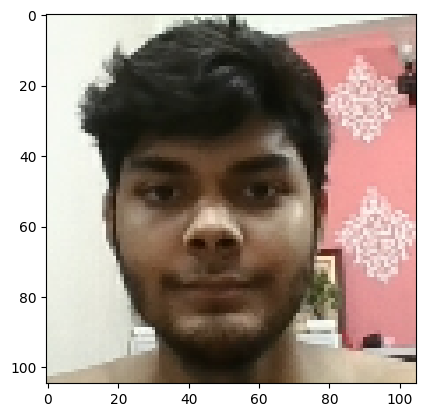

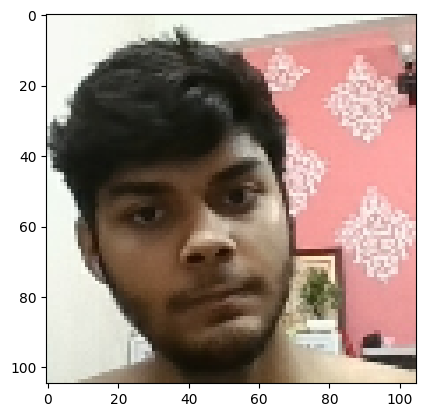

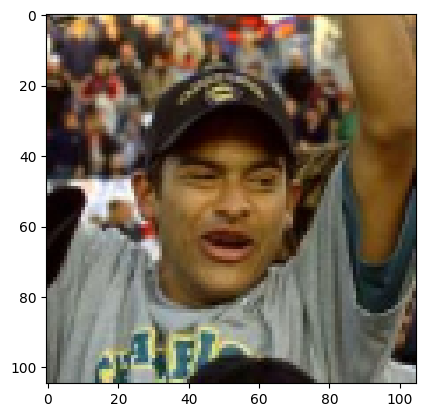

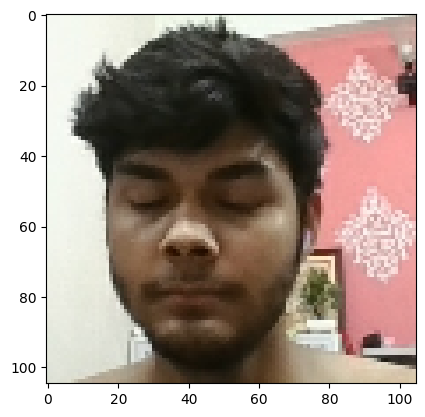

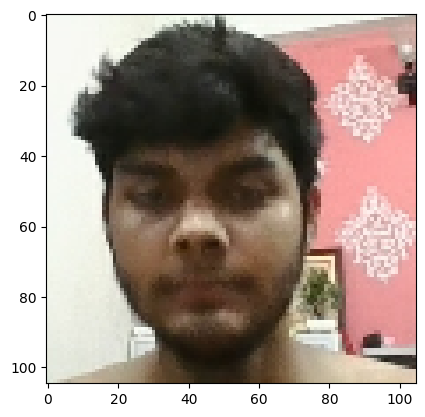

In [88]:
test_samples = test_data.as_numpy_iterator()
print(len(test_samples.next()[0]))
for img in test_samples.next()[1]:
    plt.imshow(img)
    plt.show()

### Build Embedding Layer

In [89]:
inp = Input(shape=(105, 105, 3), name='input_image')

In [90]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [91]:
def make_embedding():
    inp = Input(shape=(105, 105, 3), name='input_image')
    
#     First Block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    mp1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
#     Second Block
    c2 = Conv2D(128, (7, 7), activation='relu')(mp1)
    mp2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
#     Third Block
    c3 = Conv2D(128, (4, 4), activation='relu')(mp2)
    mp3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
#     Final Embedding Block
    c4 = Conv2D(256, (4, 4), activation='relu')(mp3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [92]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

### Build Distance Layer

In [93]:
# Siamese L1 distance class
class L1dist(Layer):
    
#     Init method - Inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
#     Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [94]:
l1 = L1dist()

In [95]:
# l1(anchor_embedding, validation_embedding)

In [96]:
l1

### Make Siamese Model

In [97]:
def make_siamese_model():
    
#     Anchor image in the network
    input_image = Input(name='input_img', shape=(105, 105, 3))
    
#     Validation image in the network
    validation_image = Input(name='validation_img', shape=(105, 105, 3))
    
#     Combine siamese distance components
    siamese_layer = L1dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
#     Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')

In [98]:
Siamese_Model = make_siamese_model()
Siamese_Model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

### Setup Loss and Optimizer

In [99]:
# Binary loss function
binary_loss = tf.losses.BinaryCrossentropy()

# Adam optimizer with 0.0001 learning rate
optimizer = tf.keras.optimizers.Adam(1e-4)

### Establish Checkpoints

In [ ]:
# Make training_checkpoints directory in the main directory
CHECKPOINT_PATH = os.path.join('training_checkpoints')
os.makedirs(CHECKPOINT_PATH)

In [100]:
checkpoint_dir = './training_checkpoints/'

# Store the checkpoints as 'ckpt' file in training_checkpoints directory
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# What the checkpoint should store in it?
checkpoint = tf.train.Checkpoint(optimizer=optimizer, Siamese_Model=Siamese_Model)

### Build Train Step Function

In [101]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
x = batch_1[:2]
y = batch_1[2]
x, y

((array([[[[0.96591973, 0.97768444, 0.9502334 ],
           [0.9647059 , 0.9764706 , 0.9490196 ],
           [0.95723623, 0.972549  , 0.94509804],
           ...,
           [0.71454805, 0.6841314 , 0.6474967 ],
           [0.6745831 , 0.6394624 , 0.6040816 ],
           [0.6676026 , 0.63249075, 0.5912231 ]],
  
          [[0.9661131 , 0.9778778 , 0.9504268 ],
           [0.9647059 , 0.9764706 , 0.9490196 ],
           [0.9611578 , 0.9764706 , 0.9490196 ],
           ...,
           [0.6974189 , 0.64615846, 0.6103041 ],
           [0.70672274, 0.6518207 , 0.6078631 ],
           [0.72063494, 0.66461253, 0.6187675 ]],
  
          [[0.96862745, 0.98039216, 0.9529412 ],
           [0.9647059 , 0.9764706 , 0.9490196 ],
           [0.9627629 , 0.9764706 , 0.9490196 ],
           ...,
           [0.7345294 , 0.65845   , 0.61316526],
           [0.73333997, 0.6503668 , 0.599193  ],
           [0.7424014 , 0.6525788 , 0.60337245]],
  
          ...,
  
          [[0.8511577 , 0.8411671 , 0.77

In [103]:
@tf.function
def train_steps(batch):
    
#     Record all operations
    with tf.GradientTape() as tape:
#         Get anchor and positive/negative images
        X = batch[:2]
#         Get label
        Y = batch[2]
        
#         Forward pass
        Y_pred = Siamese_Model(X, training=True)
#         Calculate loss
        loss = binary_loss(Y, Y_pred)
        
    print(loss)
    
#     Calculate gradients
    grad = tape.gradient(loss, Siamese_Model.trainable_variables)
    
#     Calculate updated weights and apply it to siamese model
    optimizer.apply_gradients(zip(grad, Siamese_Model.trainable_variables))
    
    return loss

### Build Training Loop

In [107]:
from tensorflow.keras.metrics import Precision, Recall

def train(data, EPOCHS):
    
#     Loop through eeach epoch
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progress_bar = tf.keras.utils.Progbar(len(data))
        
#         Creating a metric object
        r = Recall()
        p = Precision()
        
#         Loop through each batch
        for index, batch in enumerate(data):
#             Run train step here
            loss = train_steps(batch)
            Y_pred = Siamese_Model.predict(batch[:2])
            r.update_state(batch[2], Y_pred)
            p.update_state(batch[2], Y_pred)
            progress_bar.update(index+1)
            
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
            
#         Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the Model

In [ ]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 448s 17s/step
0.341611 0.46534654 1.0

 Epoch 2/50
27/27 [==============================] - 77305s 2973s/step
0.00065318425 0.9907407 0.9953488

 Epoch 3/50
27/27 [==============================] - 880s 33s/step
0.0059705963 0.97619045 1.0

 Epoch 4/50
27/27 [==============================] - 485s 18s/step
0.014818426 0.990566 1.0

 Epoch 5/50
27/27 [==============================] - 494s 18s/step
0.0016456225 1.0 1.0

 Epoch 6/50
27/27 [==============================] - 506s 19s/step
0.0013062287 1.0 1.0

 Epoch 7/50
 3/27 [==>...........................] - ETA: 7:07

### Import Metrics

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### Make Predictions

In [ ]:
# Get a batch of test data
test_input_img, test_val_img, actual_label = test_data.as_numpy_iterator().next()

In [ ]:
# Make Predictions
predictions = Siamese_Model.predict([test_input_img, test_val_img])
predictions

In [ ]:
# Post processing the predictions
[1 if predict > 0.5 else 0 for predict in predictions]
# res = []
# for predict in predictions:
#     if predict > 0.5:
#         res.append(1)
#     else:
#         res.append(0)

In [ ]:
# Cross-checking with the actual label
actual_label

### Calculate Metrics

In [ ]:
# Creating recall metric object
r = Recall()

# Calculating recall value
r.update_state(actual_label, predictions)

# Return recall result
r.result().numpy()

In [ ]:
# Creating precision metric object
p = Precision()

# Calculating precision value
p.update_state(actual_label, predictions)

# Return precision result
p.result().numpy()

### Visualize Results

In [ ]:
# Set plot size
plt.figure(figsize=(10, 8))

# Set first subplot (no. of rows, no. of columns, index of the image)
plt.subplot(1, 2, 1)
plt.imshow(test_input_img[10])

# Set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val_img[10])

# Renders cleanly
plt.show()

### Save Model

In [ ]:
# Save weights
Siamese_Model.save('siamese_model.h5')

In [ ]:
# Reload model
model = tf.keras.models.load_model('siamese_model.h5',
                                  custom_objects={'L1dist':L1dist, 'Binary_Crossentropy':tf.losses.BinaryCrossentropy()})

In [ ]:
# make predictions with reloaded model
model.predict([test_input_img, test_val_img])

In [ ]:
# View model summary
model.summary()